# Stage 08 — Exploratory Data Analysis (EDA)

Goals:
- Summarize & visualize distributions and relationships
- Interpret trends/anomalies to inform modeling
- Document insights and assumptions clearly

## 0. Setup & Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# Helper display
def title(msg):
    print('\n' + '='*len(msg))
    print(msg)
    print('='*len(msg))

## 1. Synthetic Data Generator (Reproducible)
No external CSVs required. This mimics a small financial-behavior dataset with both numeric and categorical variables and a time component.

In [41]:
n = 180  # ~6 months of daily data
dates = pd.date_range('2021-01-01', periods=n, freq='D')

regions = np.random.choice(['North','South','East','West'], size=n, p=[0.25,0.25,0.30,0.20])
age = np.random.normal(40, 8, size=n).clip(22, 70)
income = np.random.lognormal(mean=10.6, sigma=0.3, size=n)  # lognormal skew
transactions = np.random.poisson(lam=3, size=n) + (np.random.rand(n) < 0.05).astype(int)*8  # rare spikes
base_spend = (income * (0.0015 + 0.00002*(age-40)) + transactions*20)
noise = np.random.normal(0, 50, size=n)
spend = (base_spend + noise).clip(0)

# Assemble
df = pd.DataFrame({
    'date': dates,
    'region': regions,
    'age': age.round(1),
    'income': income.round(2),
    'transactions': transactions,
    'spend': spend.round(2)
})

# Inject missingness and outliers
df.loc[np.random.choice(df.index, size=6, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, size=4, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, size=2, replace=False), 'transactions'] = df['transactions'].max() + 15  # extreme outliers

df.head()

,date,region,age,income,transactions,spend
0,2021-01-01,West,51.4,27214.24,0,0.00
1,2021-01-02,West,47.4,33190.73,2,80.65
2,2021-01-03,West,35.9,46656.64,3,224.53
3,2021-01-04,East,38.6,42238.82,2,138.80
4,2021-01-05,North,32.7,74158.41,0,25.80


## 2. First Look: Structure & Sanity Checks

In [42]:
title('df.info()')
df.info()
title('Head & Tail')
display(df.head(3))
display(df.tail(3))
title('Missingness counts')
df.isna().sum()


df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          180 non-null    datetime64[ns]
 1   region        180 non-null    object        
 2   age           180 non-null    float64       
 3   income        174 non-null    float64       
 4   transactions  180 non-null    int64         
 5   spend         176 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 8.6+ KB

Head & Tail


,date,region,age,income,transactions,spend
0,2021-01-01,West,51.4,27214.24,0,0.00
1,2021-01-02,West,47.4,33190.73,2,80.65
2,2021-01-03,West,35.9,46656.64,3,224.53


,date,region,age,income,transactions,spend
177,2021-06-27,North,41.1,35894.34,4,106.56
178,2021-06-28,East,38.8,37027.03,3,63.91
179,2021-06-29,West,48.7,38398.22,7,156.45



Missingness counts


date            0
region          0
age             0
income          6
transactions    0
spend           4
dtype: int64

In [43]:
title('Descriptive statistics')
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc


Descriptive statistics


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,180.0,39.630556,7.936867,22.00,34.2750,39.500,45.3750,61.10,-0.029707,-0.244275
income,174.0,42509.641264,13209.421297,17060.87,33192.4250,40297.665,49780.3325,87052.40,0.917298,0.770198
transactions,180.0,3.777778,3.704980,0.00,2.0000,3.000,4.0000,29.00,3.997703,22.562356
spend,176.0,141.494943,73.718867,0.00,89.3425,138.935,187.7425,362.51,0.310919,0.099200


### Notes
- `income` is lognormal (positively skewed): might consider log-transform later.
- `transactions` presents rare spikes: inspect outliers vs data quality.
- Missing values exist in `income` and `spend`: decide imputation strategy before modeling.

## 3. Univariate Visuals: Distributions & Outliers

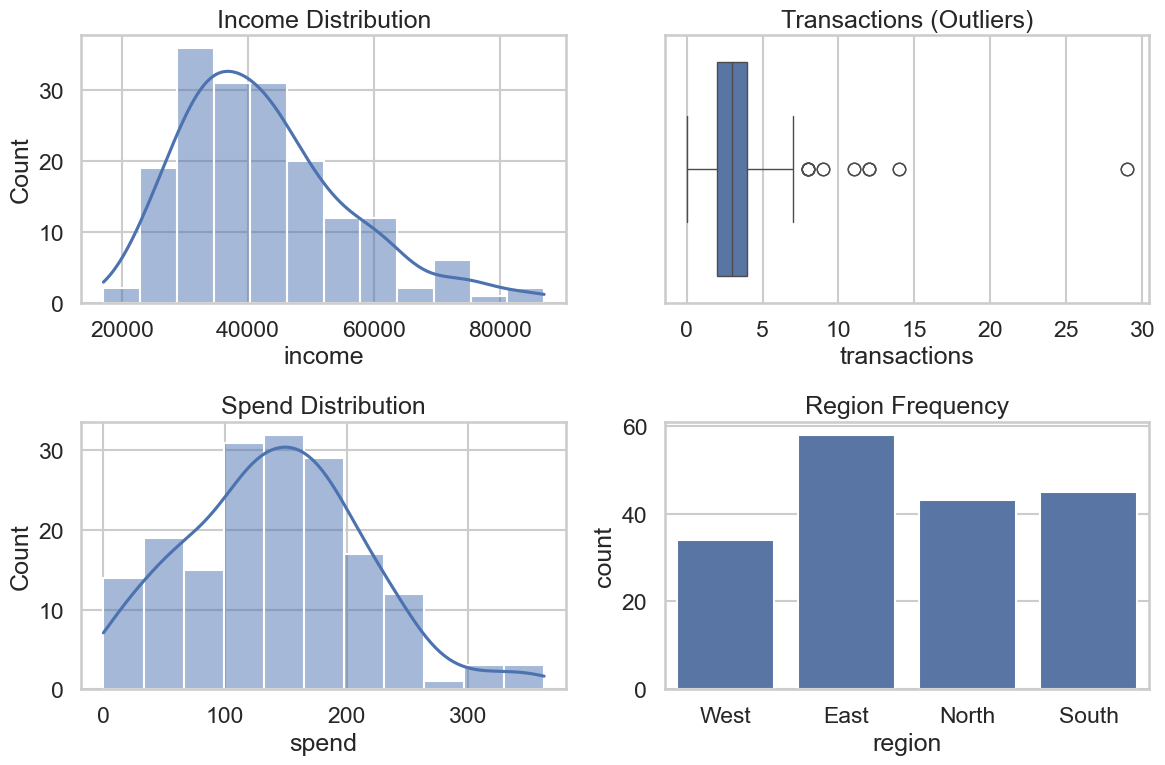

In [44]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
sns.histplot(df['income'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Income Distribution')
sns.boxplot(x=df['transactions'], ax=axes[0,1])
axes[0,1].set_title('Transactions (Outliers)')
sns.histplot(df['spend'], kde=True, ax=axes[1,0])
axes[1,0].set_title('Spend Distribution')
sns.countplot(x=df['region'], ax=axes[1,1])
axes[1,1].set_title('Region Frequency')
plt.tight_layout()
plt.show()

## 4. Bivariate Visuals: Relationships

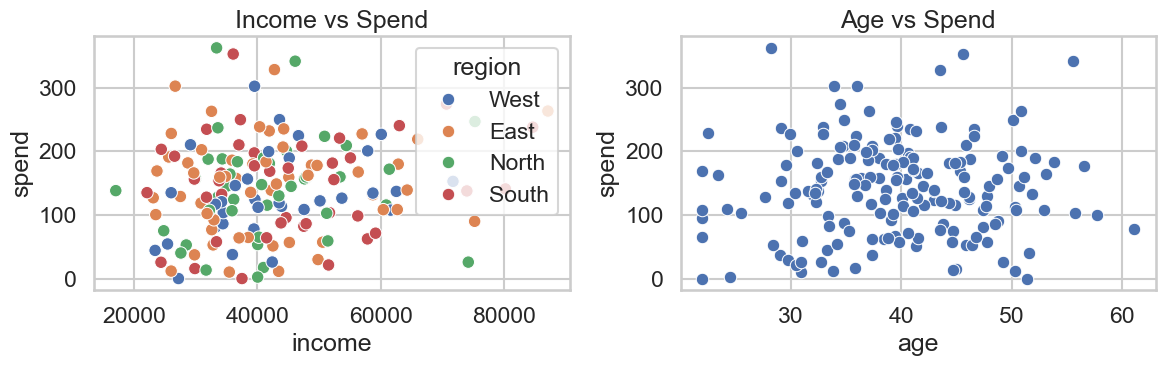

In [45]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(data=df, x='income', y='spend', hue='region', ax=axes[0])
axes[0].set_title('Income vs Spend')
sns.scatterplot(data=df, x='age', y='spend', ax=axes[1])
axes[1].set_title('Age vs Spend')
plt.tight_layout()
plt.show()

## 5. Time Series Glance

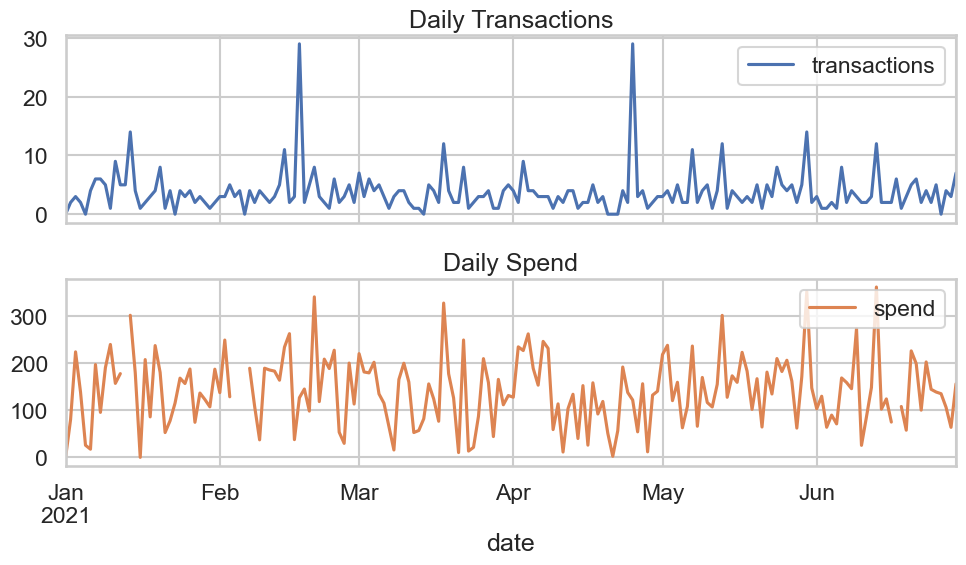

In [46]:
#daily value
daily = df.set_index('date')[['transactions','spend']]
daily.plot(subplots=True, figsize=(10,6), title=['Daily Transactions','Daily Spend'])
plt.tight_layout()
plt.show()

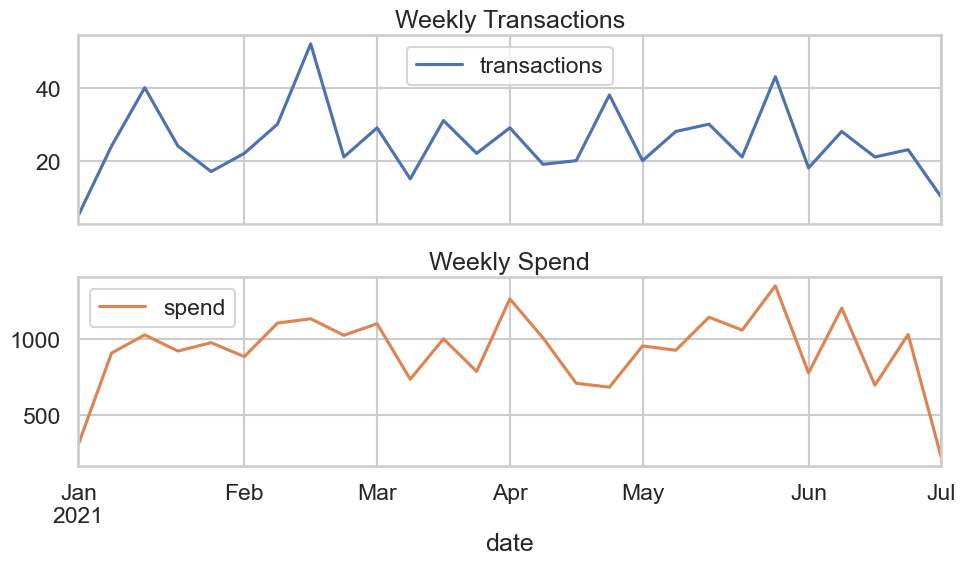

In [47]:
#weekly value
daily = df.set_index('date')[['transactions','spend']].resample('W').sum()
daily.plot(subplots=True, figsize=(10,6), title=['Weekly Transactions','Weekly Spend'])
plt.tight_layout()
plt.show()

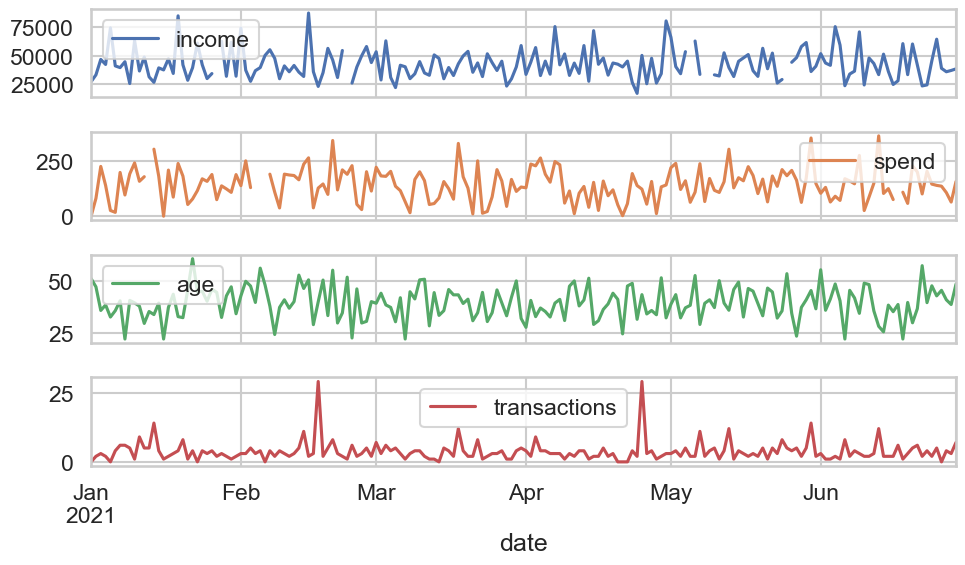

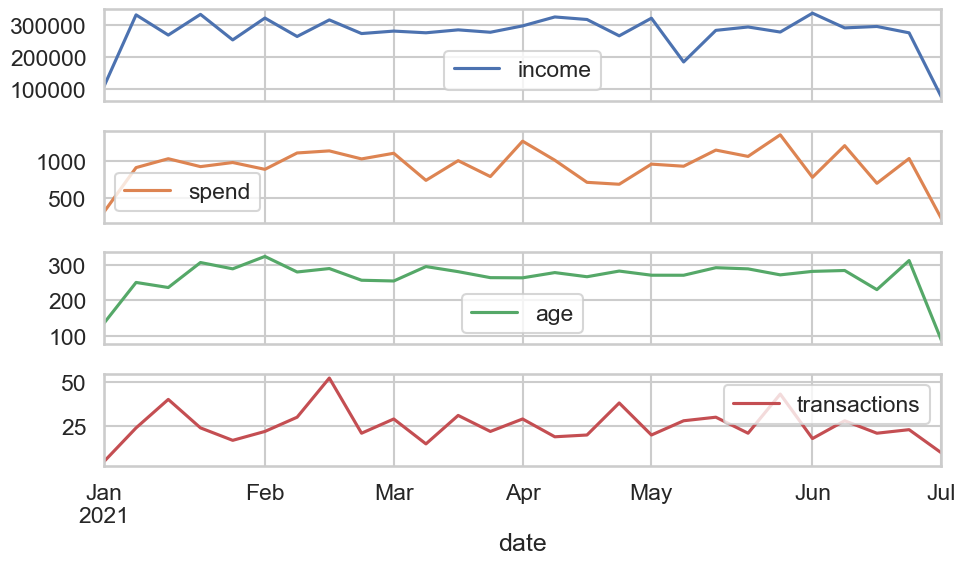

/var/folders/5d/87kx7_3555x_7x12423nl75w0000gn/T/ipykernel_23584/3664172557.py:14: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  daily = df.set_index('date')[['income','spend','age','transactions']].resample('Q').sum()


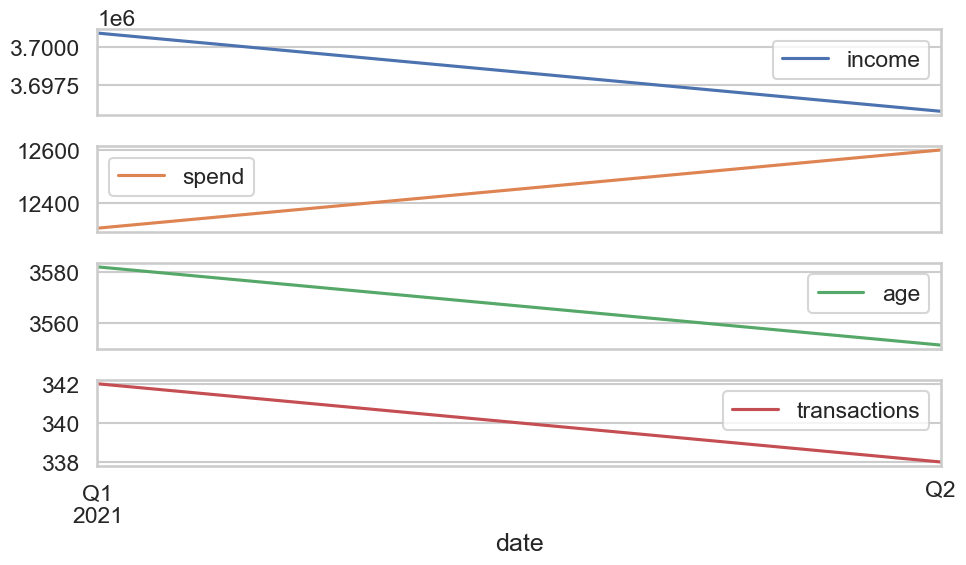

In [48]:
#daily
daily = df.set_index('date')[['income','spend','age','transactions']]
daily.plot(subplots=True, figsize=(10,6))
plt.tight_layout()
plt.show()

#weekly
daily = df.set_index('date')[['income','spend','age','transactions']].resample('W').sum()
daily.plot(subplots=True, figsize=(10,6))
plt.tight_layout()
plt.show()

#yearly (TBD ini yg bener gimana ya)
daily = df.set_index('date')[['income','spend','age','transactions']].resample('Q').sum()
daily.plot(subplots=True, figsize=(10,6))
plt.tight_layout()
plt.show()

## 6. Correlation Matrix (Optional but Recommended)

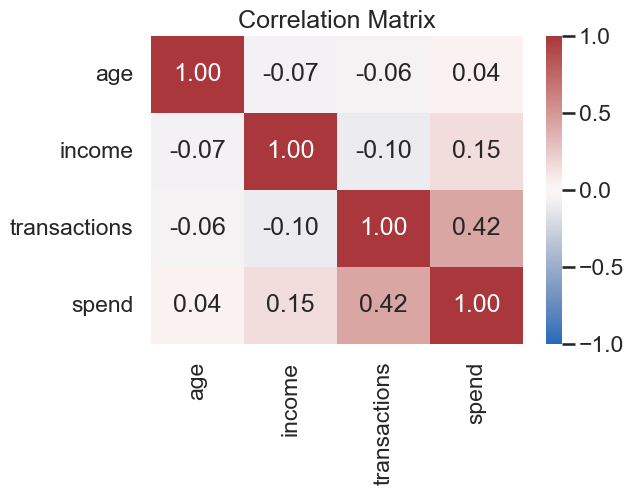

,age,income,transactions,spend
age,1.000000,-0.066301,-0.062386,0.040151
income,-0.066301,1.000000,-0.102172,0.152572
transactions,-0.062386,-0.102172,1.000000,0.423752
spend,0.040151,0.152572,0.423752,1.000000


In [49]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

## 7. Reusable Helper: `eda_summary(df)`

In [50]:
def eda_summary(df: pd.DataFrame, numeric_cols=None):
    """Return a dict with quick profiling stats and basic missingness.
    numeric_cols: optional list to limit numeric profiling.
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = {}
    out['shape'] = df.shape
    out['dtypes'] = df.dtypes.to_dict()
    out['missing'] = df.isna().sum().to_dict()
    profile = df[numeric_cols].describe().T
    profile['skew'] = [skew(df[c].dropna()) for c in profile.index]
    profile['kurtosis'] = [kurtosis(df[c].dropna()) for c in profile.index]
    out['numeric_profile'] = profile
    return out

summary = eda_summary(df)
summary['shape'], list(summary['dtypes'].items())[:3]

((180, 6),
 [('date', dtype('<M8[ns]')),
  ('region', dtype('O')),
  ('age', dtype('float64'))])

### 8. “So What?”: Insights & Assumptions
- **Skew**: `income` and `spend` are right-skewed → consider log transforms for linear models.
- **Outliers**: transactions show spikes → verify data quality; maybe winsorize.
- **Relationships**: positive `income–spend`; check nonlinearity (might motivate interaction terms later).
- **Missingness**: imputation strategy required before modeling.

**Next step**: translate these into feature hypotheses (ratios, lags, logs) in the Feature Engineering stage.

## 9. (Optional) Save Notebook Naming Pattern
Use: `notebooks/eda_<team>.ipynb`. (Skip actual disk I/O in this demo.)